# 📘 Notebook 07: Feature Selection

## 🎯 What I Plan to Achieve in This Notebook

In this notebook, I will analyze and select the most relevant features for predicting song popularity:

1. **Correlation Analysis** – Identify features most correlated with the target variable
2. **Multicollinearity Detection** – Find highly correlated feature pairs that may cause redundancy
3. **Feature Importance (Random Forest)** – Use tree-based importance scores
4. **Variance Analysis** – Identify low-variance features that add little information
5. **Final Feature Selection** – Create optimized feature sets for modeling

---

## Why Feature Selection is Important

### 1️⃣ **Improves Model Performance**

- Removes noisy/irrelevant features that confuse the model
- Reduces overfitting by simplifying the model
- Can improve accuracy by focusing on signal, not noise

### 2️⃣ **Reduces Computational Cost**

- Fewer features = faster training
- Important for cross-validation and hyperparameter tuning
- Smaller models are easier to deploy

### 3️⃣ **Improves Interpretability**

- Easier to explain which factors drive popularity
- Stakeholders can understand model decisions
- Actionable insights for music industry applications

### 4️⃣ **Based on My EDA Findings**

From earlier notebooks, I observed:
- Weak individual correlations with popularity (max ~0.13)
- Some engineered features (interaction terms) may add value
- Potential multicollinearity between similar features (e.g., `tempo` and `tempo_log`)

---

## 📋 Feature Selection Strategy

I will use **multiple methods** and combine their insights:

| Method | Purpose | Best For |
|--------|---------|----------|
| Correlation Analysis | Linear relationships with target | Linear Regression |
| VIF (Multicollinearity) | Detect redundant features | All models |
| Random Forest Importance | Non-linear feature importance | Tree-based models |
| Variance Threshold | Remove near-constant features | All models |

---

## 📊 Expected Outcome

By the end of this notebook, I will have:

✅ Ranked features by importance using multiple methods  
✅ Identified and addressed multicollinearity issues  
✅ Created optimized feature sets for different models  
✅ Documented feature selection rationale for interpretability  
✅ Saved selected features for use in modeling notebook

<p align="center">
  <img src="../assets/dividerlines.png" width="600"/>
</p>

## Section 1: Environment Setup and Data Loading

In [1]:
# =============================================================================
# LIBRARY IMPORTS
# =============================================================================

# Core data manipulation
import pandas as pd                    # DataFrame operations
import numpy as np                     # Numerical computations

# Visualization
import matplotlib.pyplot as plt        # Plotting
import seaborn as sns                  # Statistical visualizations

# Scikit-learn: Feature Selection & Models
from sklearn.ensemble import RandomForestRegressor     # For feature importance
from sklearn.feature_selection import VarianceThreshold  # Low variance filter
from sklearn.feature_selection import SelectKBest, f_regression  # Univariate selection

# Statistical tests
from scipy import stats                # Statistical functions

# For VIF calculation
from statsmodels.stats.outliers_influence import variance_inflation_factor

# File operations
import json
import os

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("✅ All libraries imported successfully")

✅ All libraries imported successfully


In [2]:
# =============================================================================
# DATA LOADING
# =============================================================================
# Load the scaled training data from Notebook 06
# We use training data for feature selection to prevent data leakage

X_train = pd.read_csv('../data/X_train_scaled.csv')
y_train = pd.read_csv('../data/y_train.csv').squeeze()  # Convert to Series

# Also load test data for later verification
X_test = pd.read_csv('../data/X_test_scaled.csv')
y_test = pd.read_csv('../data/y_test.csv').squeeze()

print(f"Training set: X={X_train.shape}, y={y_train.shape}")
print(f"Test set: X={X_test.shape}, y={y_test.shape}")
print(f"\nFeatures ({len(X_train.columns)}): {X_train.columns.tolist()}")

Training set: X=(71792, 24), y=(71792,)
Test set: X=(17948, 24), y=(17948,)

Features (24): ['duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'duration_min', 'energy_x_danceability', 'loudness_x_energy', 'valence_x_danceability', 'is_instrumental', 'has_vocals', 'is_speech_heavy', 'tempo_log', 'duration_category', 'track_genre']


In [3]:
# =============================================================================
# LOAD FEATURE CONFIGURATION FROM SCALING NOTEBOOK
# =============================================================================
# This tells us which features were scaled vs. left unchanged

with open('../models/feature_config.json', 'r') as f:
    feature_config = json.load(f)

print("Feature Configuration:")
print(f"  Target: {feature_config['target']}")
print(f"  Scaled features: {len(feature_config['features_scaled'])}")
print(f"  Binary features: {len(feature_config['features_binary'])}")
print(f"  Bounded features: {len(feature_config['features_bounded'])}")
print(f"  Ordinal features: {len(feature_config['features_ordinal'])}")

Feature Configuration:
  Target: popularity
  Scaled features: 9
  Binary features: 5
  Bounded features: 7
  Ordinal features: 3


<p align="center">
  <img src="../assets/dividerlines.png" width="600"/>
</p>

## Section 2: Correlation Analysis with Target

First, I'll examine how each feature correlates with the target variable (popularity). This helps identify:
- Features with strong linear relationships (useful for Linear Regression)
- Features with weak/no relationship (candidates for removal)

In [4]:
# =============================================================================
# CORRELATION WITH TARGET VARIABLE
# =============================================================================
# Calculate Pearson correlation between each feature and popularity
# Pearson measures LINEAR relationships (-1 to +1)

# Combine features and target for correlation calculation
train_data = X_train.copy()
train_data['popularity'] = y_train.values

# Calculate correlations with target
target_correlations = train_data.corr()['popularity'].drop('popularity')

# Sort by absolute correlation (strongest relationships first)
target_corr_sorted = target_correlations.abs().sort_values(ascending=False)

print("=" * 60)
print("FEATURE CORRELATIONS WITH POPULARITY")
print("=" * 60)
print("\nRanked by absolute correlation strength:\n")

for feat in target_corr_sorted.index:
    corr_val = target_correlations[feat]
    abs_corr = abs(corr_val)
    # Visual indicator of strength
    if abs_corr >= 0.1:
        strength = "🟢 Strong"
    elif abs_corr >= 0.05:
        strength = "🟡 Moderate"
    else:
        strength = "🔴 Weak"
    print(f"  {feat:<30} {corr_val:+.4f}  {strength}")

FEATURE CORRELATIONS WITH POPULARITY

Ranked by absolute correlation strength:

  track_genre                    +0.5720  🟢 Strong
  instrumentalness               -0.1267  🟢 Strong
  has_vocals                     +0.1234  🟢 Strong
  is_instrumental                -0.1206  🟢 Strong
  loudness                       +0.0874  🟡 Moderate
  danceability                   +0.0637  🟡 Moderate
  loudness_x_energy              +0.0576  🟡 Moderate
  explicit                       +0.0557  🟡 Moderate
  speechiness                    -0.0449  🔴 Weak
  acousticness                   -0.0408  🔴 Weak
  time_signature                 +0.0378  🔴 Weak
  energy_x_danceability          +0.0376  🔴 Weak
  duration_min                   -0.0224  🔴 Weak
  duration_ms                    -0.0224  🔴 Weak
  liveness                       -0.0183  🔴 Weak
  mode                           -0.0150  🔴 Weak
  valence                        -0.0150  🔴 Weak
  energy                         +0.0136  🔴 Weak
  duration_cat

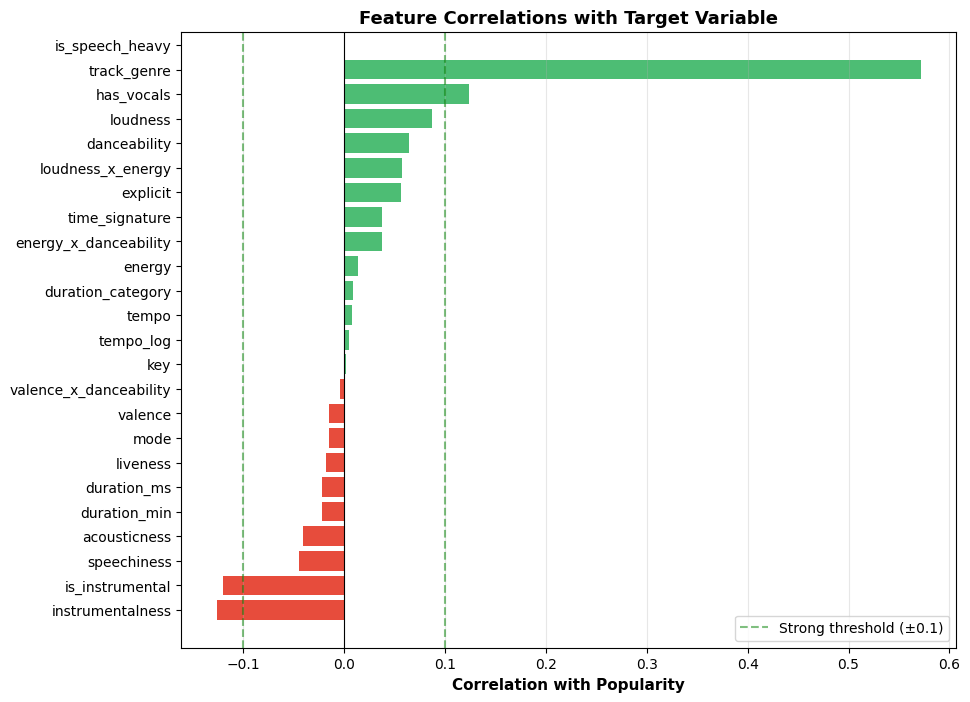

In [6]:
# =============================================================================
# VISUALIZE TARGET CORRELATIONS
# =============================================================================
# Horizontal bar chart showing correlation strength with popularity

fig, ax = plt.subplots(figsize=(10, 8))

# Sort for visualization
corr_sorted = target_correlations.sort_values()

# Color based on positive/negative correlation
colors = ['#e74c3c' if x < 0 else '#4dbd74' for x in corr_sorted.values]

# Create horizontal bar chart
bars = ax.barh(corr_sorted.index, corr_sorted.values, color=colors)

# Add vertical line at 0
ax.axvline(x=0, color='black', linewidth=0.8)

# Add threshold lines
ax.axvline(x=0.1, color='green', linestyle='--', alpha=0.5, label='Strong threshold (±0.1)')
ax.axvline(x=-0.1, color='green', linestyle='--', alpha=0.5)

ax.set_xlabel('Correlation with Popularity', fontsize=11, fontweight='bold')
ax.set_title('Feature Correlations with Target Variable', fontsize=13, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3, axis='x')

plt.show()



In [7]:
# =============================================================================
# CORRELATION INSIGHTS
# =============================================================================
# Categorize features based on correlation strength

strong_positive = target_correlations[target_correlations >= 0.1].index.tolist()
strong_negative = target_correlations[target_correlations <= -0.1].index.tolist()
moderate = target_correlations[(target_correlations.abs() >= 0.05) & 
                                (target_correlations.abs() < 0.1)].index.tolist()
weak = target_correlations[target_correlations.abs() < 0.05].index.tolist()

print("=" * 60)
print("CORRELATION SUMMARY")
print("=" * 60)

print(f"\n🟢 Strong Positive (≥ 0.1): {len(strong_positive)}")
for f in strong_positive:
    print(f"   - {f}: {target_correlations[f]:+.4f}")

print(f"\n🔴 Strong Negative (≤ -0.1): {len(strong_negative)}")
for f in strong_negative:
    print(f"   - {f}: {target_correlations[f]:+.4f}")

print(f"\n🟡 Moderate (0.05-0.1): {len(moderate)}")
for f in moderate:
    print(f"   - {f}: {target_correlations[f]:+.4f}")

print(f"\n⚪ Weak (< 0.05): {len(weak)}")
print(f"   {weak}")

CORRELATION SUMMARY

🟢 Strong Positive (≥ 0.1): 2
   - has_vocals: +0.1234
   - track_genre: +0.5720

🔴 Strong Negative (≤ -0.1): 2
   - instrumentalness: -0.1267
   - is_instrumental: -0.1206

🟡 Moderate (0.05-0.1): 4
   - explicit: +0.0557
   - danceability: +0.0637
   - loudness: +0.0874
   - loudness_x_energy: +0.0576

⚪ Weak (< 0.05): 15
   ['duration_ms', 'energy', 'key', 'mode', 'speechiness', 'acousticness', 'liveness', 'valence', 'tempo', 'time_signature', 'duration_min', 'energy_x_danceability', 'valence_x_danceability', 'tempo_log', 'duration_category']


<p align="center">
  <img src="../assets/dividerlines.png" width="600"/>
</p>

## Section 3: Multicollinearity Analysis

Multicollinearity occurs when features are highly correlated with each other. This can:
- Make Linear Regression coefficients unstable
- Add redundant information without improving predictions
- Make interpretation difficult

I'll use two methods:
1. **Correlation Heatmap** - Visual inspection of feature-feature correlations
2. **VIF (Variance Inflation Factor)** - Quantitative measure of multicollinearity

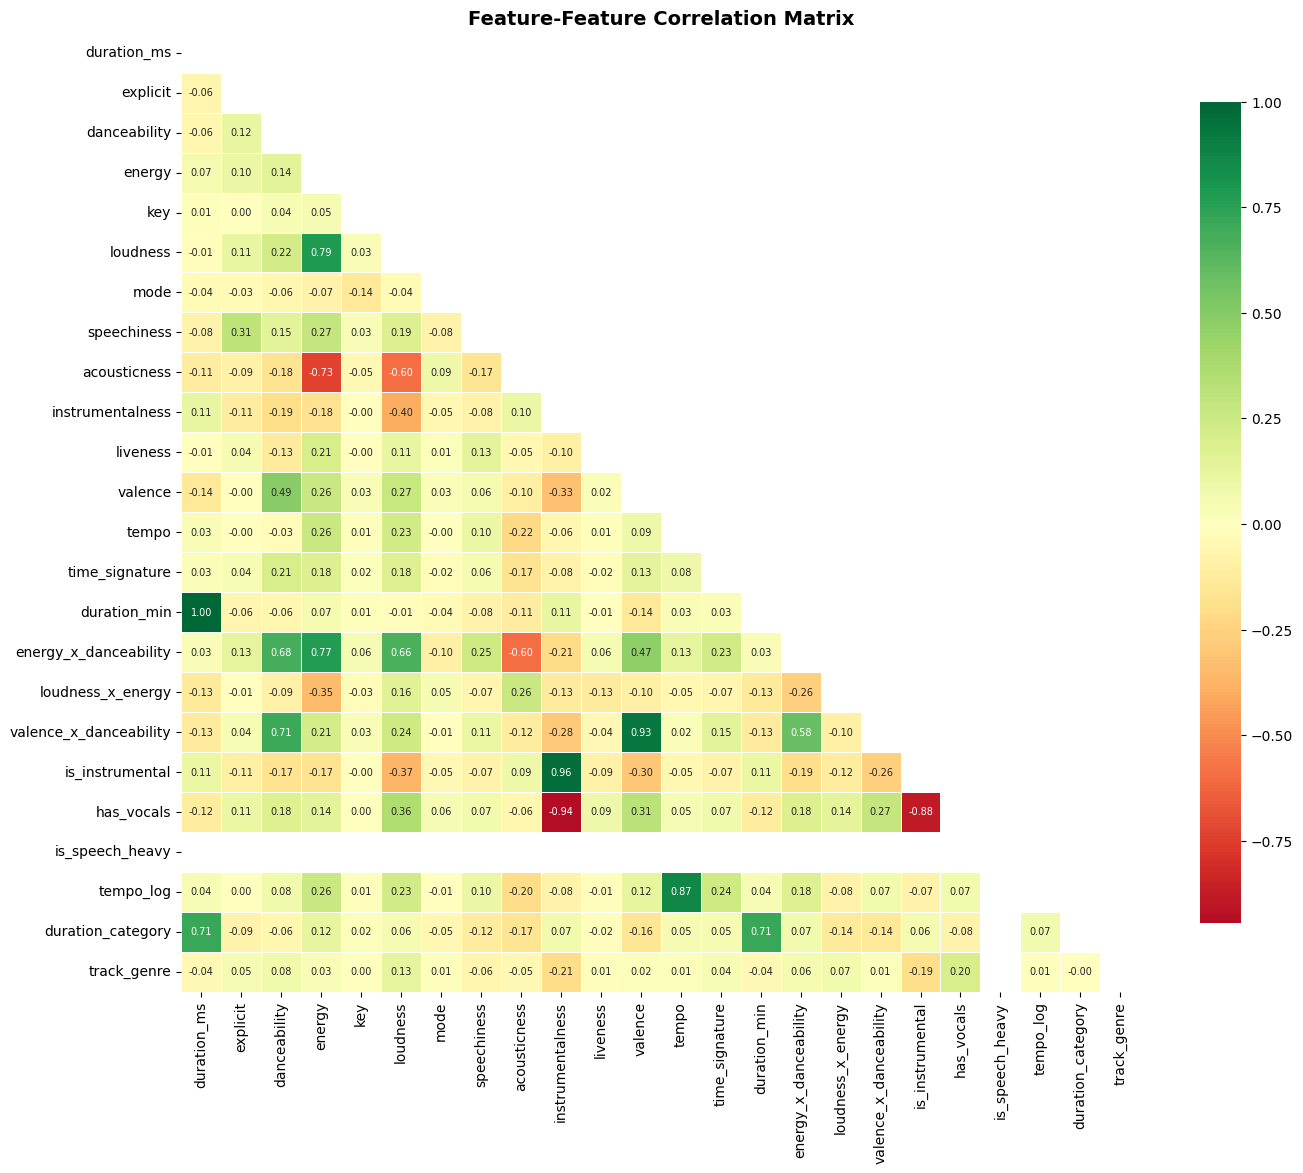

In [9]:
# =============================================================================
# FEATURE-FEATURE CORRELATION MATRIX
# =============================================================================
# Calculate pairwise correlations between all features

feature_corr = X_train.corr()

# Create heatmap
plt.figure(figsize=(14, 12))

# Use mask to show only lower triangle (avoid redundancy)
mask = np.triu(np.ones_like(feature_corr, dtype=bool))

sns.heatmap(
    feature_corr,
    mask=mask,
    annot=True,
    fmt='.2f',
    cmap='RdYlGn',
    center=0,
    square=True,
    linewidths=0.5,
    annot_kws={'size': 7},
    cbar_kws={'shrink': 0.8}
)

plt.title('Feature-Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()

plt.show()



In [14]:
# =============================================================================
# IDENTIFY HIGHLY CORRELATED FEATURE PAIRS
# =============================================================================
# Find pairs with |correlation| > 0.7 (potential multicollinearity)

threshold = 0.7

# Get upper triangle indices (avoid duplicates and diagonal)
high_corr_pairs = []

for i in range(len(feature_corr.columns)):
    for j in range(i+1, len(feature_corr.columns)):
        corr_val = feature_corr.iloc[i, j]
        if abs(corr_val) > threshold:
            high_corr_pairs.append({
                'feature_1': feature_corr.columns[i],
                'feature_2': feature_corr.columns[j],
                'correlation': corr_val
            })

print("=" * 60)
print(f"HIGHLY CORRELATED FEATURE PAIRS (|r| > {threshold})")
print("=" * 60)

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('correlation', 
                                                              key=abs, 
                                                              ascending=False)
    print("\n" + high_corr_df.to_string(index=False))
else:
    print("\n✅ No highly correlated feature pairs found!")

HIGHLY CORRELATED FEATURE PAIRS (|r| > 0.7)

       feature_1              feature_2  correlation
     duration_ms           duration_min     1.000000
instrumentalness        is_instrumental     0.962321
instrumentalness             has_vocals    -0.944137
         valence valence_x_danceability     0.928528
 is_instrumental             has_vocals    -0.883197
           tempo              tempo_log     0.869366
          energy               loudness     0.786928
          energy  energy_x_danceability     0.773430
          energy           acousticness    -0.732260
     duration_ms      duration_category     0.714647
    duration_min      duration_category     0.714647
    danceability valence_x_danceability     0.708398


Recommendation:
   - Consider removing one feature from each highly correlated pair
   - Keep the feature with higher correlation to target

In [15]:
# =============================================================================
# VARIANCE INFLATION FACTOR (VIF)
# =============================================================================
# VIF measures how much a feature's variance is inflated due to collinearity
#
# Interpretation:
#   VIF = 1: No correlation with other features
#   VIF 1-5: Low to moderate correlation (acceptable)
#   VIF 5-10: High correlation (concerning)
#   VIF > 10: Very high correlation (problematic, consider removal)

def calculate_vif(X):
    """
    Calculate VIF for each feature in the dataframe.
    
    Parameters:
    -----------
    X : pandas DataFrame
        Feature matrix
        
    Returns:
    --------
    vif_df : pandas DataFrame
        DataFrame with features and their VIF values
    """
    vif_data = []
    
    for i, col in enumerate(X.columns):
        try:
            vif = variance_inflation_factor(X.values, i)
            vif_data.append({'feature': col, 'VIF': vif})
        except:
            vif_data.append({'feature': col, 'VIF': np.nan})
    
    return pd.DataFrame(vif_data).sort_values('VIF', ascending=False)

print("=" * 60)
print("VARIANCE INFLATION FACTOR (VIF) ANALYSIS")
print("=" * 60)
print("\nCalculating VIF for all features...")

vif_df = calculate_vif(X_train)

print("\nVIF Values (sorted by highest):")
print("-" * 40)

for _, row in vif_df.iterrows():
    vif_val = row['VIF']
    feat = row['feature']
    
    if vif_val > 10:
        status = "🔴 REMOVE"
    elif vif_val > 5:
        status = "🟡 WATCH"
    else:
        status = "🟢 OK"
    
    print(f"  {feat:<30} VIF: {vif_val:>8.2f}  {status}")

VARIANCE INFLATION FACTOR (VIF) ANALYSIS

Calculating VIF for all features...

VIF Values (sorted by highest):
----------------------------------------
  duration_ms                    VIF:      inf  🔴 REMOVE
  duration_min                   VIF:      inf  🔴 REMOVE
  energy                         VIF:    92.68  🔴 REMOVE
  time_signature                 VIF:    79.47  🔴 REMOVE
  valence                        VIF:    58.77  🔴 REMOVE
  has_vocals                     VIF:    40.63  🔴 REMOVE
  instrumentalness               VIF:    38.53  🔴 REMOVE
  danceability                   VIF:    38.35  🔴 REMOVE
  valence_x_danceability         VIF:    20.25  🔴 REMOVE
  is_instrumental                VIF:    18.19  🔴 REMOVE
  energy_x_danceability          VIF:    11.09  🔴 REMOVE
  duration_category              VIF:     9.85  🟡 WATCH
  loudness                       VIF:     7.15  🟡 WATCH
  tempo_log                      VIF:     4.59  🟢 OK
  tempo                          VIF:     4.57  🟢 OK
  s

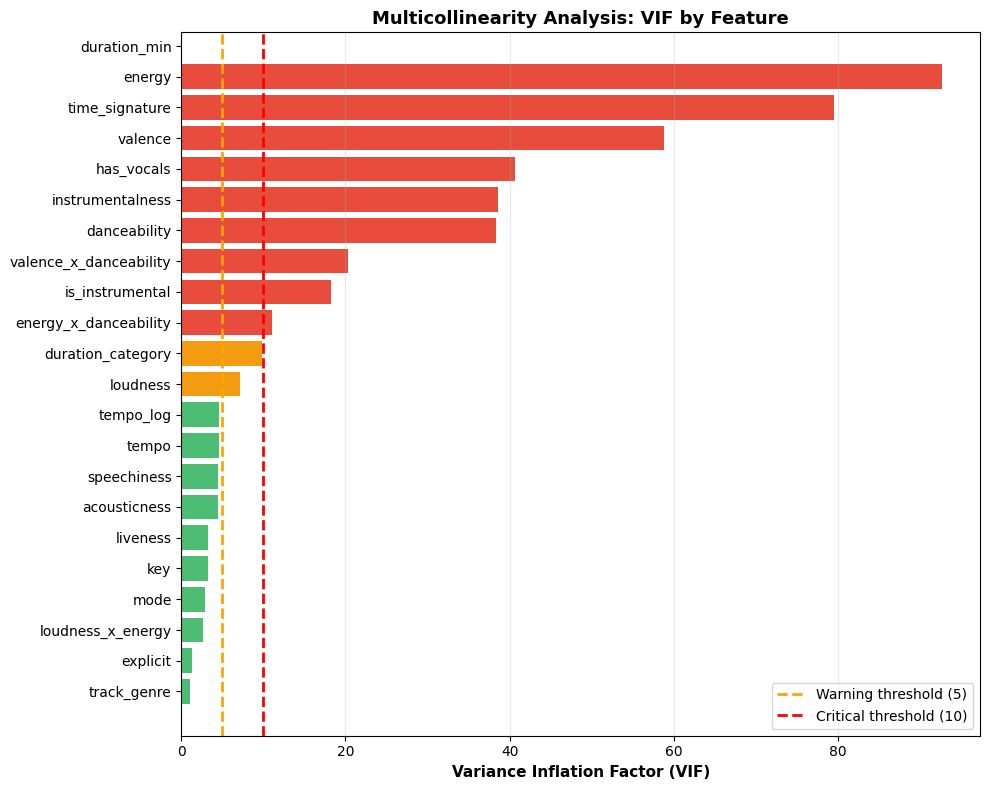

In [17]:
# =============================================================================
# VISUALIZE VIF VALUES
# =============================================================================

fig, ax = plt.subplots(figsize=(10, 8))

# Sort by VIF
vif_sorted = vif_df.sort_values('VIF', ascending=True)

# Color based on VIF threshold
colors = []
for vif in vif_sorted['VIF']:
    if vif > 10:
        colors.append('#e74c3c')  # Red - problematic
    elif vif > 5:
        colors.append('#f39c12')  # Orange - concerning
    else:
        colors.append('#4dbd74')  # Green - OK

ax.barh(vif_sorted['feature'], vif_sorted['VIF'], color=colors)

# Add threshold lines
ax.axvline(x=5, color='orange', linestyle='--', linewidth=2, label='Warning threshold (5)')
ax.axvline(x=10, color='red', linestyle='--', linewidth=2, label='Critical threshold (10)')

ax.set_xlabel('Variance Inflation Factor (VIF)', fontsize=11, fontweight='bold')
ax.set_title('Multicollinearity Analysis: VIF by Feature', fontsize=13, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()



<p align="center">
  <img src="../assets/dividerlines.png" width="600"/>
</p>

## Section 4: Feature Importance Using Random Forest

Random Forest provides feature importance scores that capture **non-linear relationships**. This complements correlation analysis which only measures linear relationships.

How it works:
- Features used for splitting at root nodes are more important
- Importance = reduction in impurity (variance) weighted by samples reaching the node

In [18]:
# =============================================================================
# RANDOM FOREST FEATURE IMPORTANCE
# =============================================================================
# Train a Random Forest to get feature importance scores
# Using a relatively small model for speed (not for final predictions)

print("Training Random Forest for feature importance...")

# Initialize Random Forest with reasonable hyperparameters
rf_model = RandomForestRegressor(
    n_estimators=100,      # Number of trees
    max_depth=10,          # Limit depth for speed
    min_samples_split=10,  # Minimum samples to split
    random_state=42,       # Reproducibility
    n_jobs=-1              # Use all CPU cores
)

# Fit on training data
rf_model.fit(X_train, y_train)

# Extract feature importances
rf_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n" + "=" * 60)
print("RANDOM FOREST FEATURE IMPORTANCE")
print("=" * 60)
print("\nRanked by importance:\n")

for i, row in rf_importance.iterrows():
    importance_pct = row['importance'] * 100
    bar = '█' * int(importance_pct * 2)  # Visual bar
    print(f"  {row['feature']:<30} {importance_pct:>5.2f}%  {bar}")

Training Random Forest for feature importance...

RANDOM FOREST FEATURE IMPORTANCE

Ranked by importance:

  track_genre                    77.10%  ██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████
  acousticness                    2.41%  ████
  danceability                    1.98%  ███
  energy_x_danceability           1.82%  ███
  energy                          1.60%  ███
  valence                         1.60%  ███
  liveness                        1.45%  ██
  loudness_x_energy               1.37%  ██
  speechiness                     1.33%  ██
  loudness                        1.32%  ██
  instrumentalness                1.28%  ██
  valence_x_danceability          1.22%  ██
  duration_ms                     1.18%  ██
  duration_min                    1.15%  ██
  explicit                        0.82%  █
  tempo                           0.81%  █
  tempo_log                      

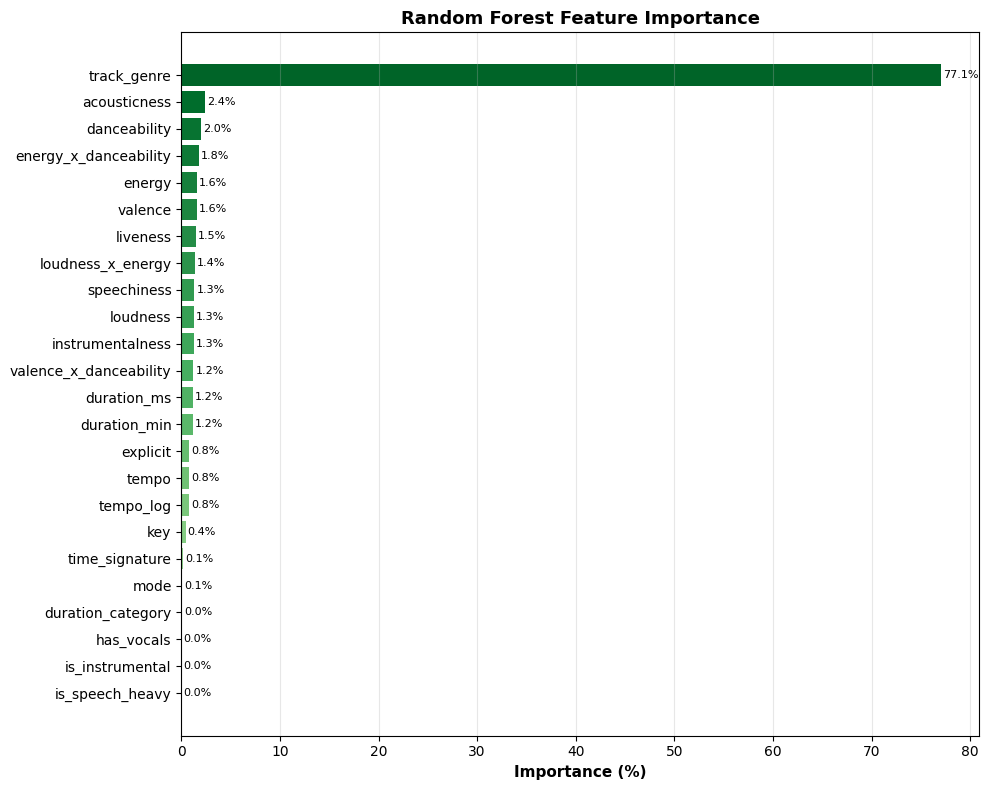

In [20]:
# =============================================================================
# VISUALIZE RANDOM FOREST IMPORTANCE
# =============================================================================

fig, ax = plt.subplots(figsize=(10, 8))

# Sort for visualization (ascending for horizontal bar)
rf_sorted = rf_importance.sort_values('importance', ascending=True)

# Create color gradient based on importance
colors = plt.cm.Greens(np.linspace(0.3, 0.9, len(rf_sorted)))

ax.barh(rf_sorted['feature'], rf_sorted['importance'] * 100, color=colors)

ax.set_xlabel('Importance (%)', fontsize=11, fontweight='bold')
ax.set_title('Random Forest Feature Importance', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# Add percentage labels on bars
for i, (idx, row) in enumerate(rf_sorted.iterrows()):
    ax.text(row['importance'] * 100 + 0.2, i, f"{row['importance']*100:.1f}%", 
            va='center', fontsize=8)

plt.tight_layout()
plt.show()



In [21]:
# =============================================================================
# CUMULATIVE IMPORTANCE ANALYSIS
# =============================================================================
# Determine how many features needed to capture X% of total importance

rf_importance_sorted = rf_importance.sort_values('importance', ascending=False).reset_index(drop=True)
rf_importance_sorted['cumulative'] = rf_importance_sorted['importance'].cumsum()
rf_importance_sorted['cumulative_pct'] = rf_importance_sorted['cumulative'] * 100

print("=" * 60)
print("CUMULATIVE FEATURE IMPORTANCE")
print("=" * 60)
print("\nHow many features to reach importance threshold:\n")

thresholds = [0.50, 0.75, 0.90, 0.95]

for thresh in thresholds:
    n_features = (rf_importance_sorted['cumulative'] <= thresh).sum() + 1
    n_features = min(n_features, len(rf_importance_sorted))
    print(f"  {thresh*100:.0f}% importance: Top {n_features} features")

print("\n📝 Top features capturing 90% of importance:")
top_90 = rf_importance_sorted[rf_importance_sorted['cumulative'] <= 0.90]['feature'].tolist()
# Include the next feature that pushes over 90%
if len(top_90) < len(rf_importance_sorted):
    top_90.append(rf_importance_sorted.iloc[len(top_90)]['feature'])
print(f"  {top_90}")

CUMULATIVE FEATURE IMPORTANCE

How many features to reach importance threshold:

  50% importance: Top 1 features
  75% importance: Top 1 features
  90% importance: Top 9 features
  95% importance: Top 13 features

📝 Top features capturing 90% of importance:
  ['track_genre', 'acousticness', 'danceability', 'energy_x_danceability', 'energy', 'valence', 'liveness', 'loudness_x_energy', 'speechiness']


<p align="center">
  <img src="../assets/dividerlines.png" width="600"/>
</p>

## Section 5: Compare Feature Selection Methods

Now I'll combine insights from all methods to make informed feature selection decisions.

In [22]:
# =============================================================================
# COMBINE ALL FEATURE RANKINGS
# =============================================================================
# Create a unified view of feature importance from different methods

# Create ranking dataframe
feature_rankings = pd.DataFrame({'feature': X_train.columns})

# Add correlation with target (absolute value for ranking)
feature_rankings['corr_with_target'] = feature_rankings['feature'].map(
    lambda x: abs(target_correlations[x])
)
feature_rankings['corr_rank'] = feature_rankings['corr_with_target'].rank(ascending=False)

# Add Random Forest importance
rf_imp_dict = dict(zip(rf_importance['feature'], rf_importance['importance']))
feature_rankings['rf_importance'] = feature_rankings['feature'].map(rf_imp_dict)
feature_rankings['rf_rank'] = feature_rankings['rf_importance'].rank(ascending=False)

# Add VIF (lower is better, so invert for ranking)
vif_dict = dict(zip(vif_df['feature'], vif_df['VIF']))
feature_rankings['vif'] = feature_rankings['feature'].map(vif_dict)
feature_rankings['vif_rank'] = feature_rankings['vif'].rank(ascending=True)  # Lower VIF = better rank

# Calculate average rank (lower = better overall)
feature_rankings['avg_rank'] = (
    feature_rankings['corr_rank'] + 
    feature_rankings['rf_rank'] + 
    feature_rankings['vif_rank']
) / 3

# Sort by average rank
feature_rankings = feature_rankings.sort_values('avg_rank')

print("=" * 80)
print("COMBINED FEATURE RANKINGS")
print("=" * 80)
print("\n(Lower rank = better feature)\n")
print(feature_rankings[['feature', 'corr_rank', 'rf_rank', 'vif_rank', 'avg_rank']].to_string(index=False))

COMBINED FEATURE RANKINGS

(Lower rank = better feature)

               feature  corr_rank  rf_rank  vif_rank  avg_rank
           track_genre        1.0      1.0       1.0  1.000000
     loudness_x_energy        7.0      8.0       3.0  6.000000
          acousticness       10.0      2.0       7.0  6.333333
              explicit        8.0     15.0       2.0  8.333333
          danceability        6.0      3.0      16.0  8.333333
           speechiness        9.0      9.0       8.0  8.666667
              loudness        5.0     10.0      11.0  8.666667
              liveness       15.0      7.0       6.0  9.333333
 energy_x_danceability       12.0      4.0      13.0  9.666667
      instrumentalness        2.0     11.0      17.0 10.000000
                  mode       16.0     20.0       4.0 13.333333
       is_instrumental        4.0     23.0      14.0 13.666667
               valence       17.0      6.0      19.0 14.000000
            has_vocals        3.0     22.0      18.0 14.3333

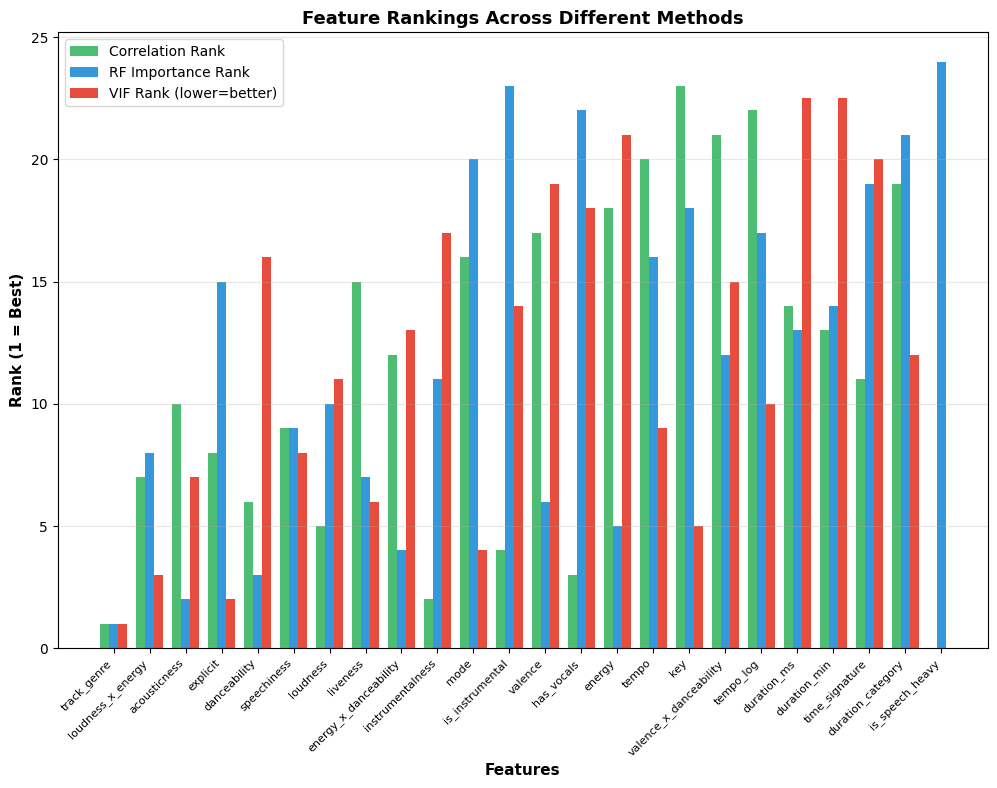

In [24]:
# =============================================================================
# VISUALIZE RANKING COMPARISON
# =============================================================================

fig, ax = plt.subplots(figsize=(12, 8))

# Prepare data for grouped bar chart
features = feature_rankings['feature'].tolist()
x = np.arange(len(features))
width = 0.25

# Create bars for each ranking method
bars1 = ax.bar(x - width, feature_rankings['corr_rank'], width, label='Correlation Rank', color='#4dbd74')
bars2 = ax.bar(x, feature_rankings['rf_rank'], width, label='RF Importance Rank', color='#3498db')
bars3 = ax.bar(x + width, feature_rankings['vif_rank'], width, label='VIF Rank (lower=better)', color='#e74c3c')

ax.set_xlabel('Features', fontsize=11, fontweight='bold')
ax.set_ylabel('Rank (1 = Best)', fontsize=11, fontweight='bold')
ax.set_title('Feature Rankings Across Different Methods', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(features, rotation=45, ha='right', fontsize=8)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')


plt.show()



<p align="center">
  <img src="../assets/dividerlines.png" width="600"/>
</p>

## Section 6: Final Feature Selection Decisions

Based on all analyses, I'll create different feature sets for modeling:
1. **Full Feature Set** - All 24 features (baseline)
2. **Reduced Feature Set** - Remove highly correlated/high VIF features
3. **Top Features Set** - Only top performers from combined ranking

In [25]:
# =============================================================================
# FEATURE SELECTION DECISIONS
# =============================================================================
# Based on the analysis, I'll define feature sets for modeling

# -----------------------------------------------------------------------------
# FULL FEATURE SET (Baseline - all features)
# -----------------------------------------------------------------------------
features_full = X_train.columns.tolist()

# -----------------------------------------------------------------------------
# REDUCED FEATURE SET (Remove redundant features)
# -----------------------------------------------------------------------------
# Criteria for removal:
#   1. Very high VIF (>10) - indicates multicollinearity
#   2. High correlation with another feature (keep the one with better target correlation)
#   3. Very weak target correlation AND low RF importance

features_to_remove = []

# Check for high VIF features
high_vif_features = vif_df[vif_df['VIF'] > 10]['feature'].tolist()
if high_vif_features:
    print(f"High VIF features (>10): {high_vif_features}")
    # For each high VIF feature, check if it's valuable
    for feat in high_vif_features:
        target_corr = abs(target_correlations.get(feat, 0))
        rf_imp = rf_imp_dict.get(feat, 0)
        # Remove if both weak correlation AND low importance
        if target_corr < 0.05 and rf_imp < 0.03:
            features_to_remove.append(feat)
            print(f"  → Removing {feat} (weak correlation & low importance)")

# Check for redundant features from high correlation pairs
if high_corr_pairs:
    print(f"\nHigh correlation pairs found: {len(high_corr_pairs)}")
    for pair in high_corr_pairs:
        f1, f2 = pair['feature_1'], pair['feature_2']
        # Keep the feature with higher target correlation
        corr1 = abs(target_correlations.get(f1, 0))
        corr2 = abs(target_correlations.get(f2, 0))
        remove_feat = f2 if corr1 >= corr2 else f1
        if remove_feat not in features_to_remove:
            features_to_remove.append(remove_feat)
            print(f"  → Removing {remove_feat} (correlated with {f1 if remove_feat == f2 else f2})")

# Create reduced feature set
features_reduced = [f for f in features_full if f not in features_to_remove]

# -----------------------------------------------------------------------------
# TOP FEATURES SET (Best performers only)
# -----------------------------------------------------------------------------
# Select top 50% of features based on average ranking
n_top = len(features_full) // 2
features_top = feature_rankings.head(n_top)['feature'].tolist()

print("\n" + "=" * 60)
print("FEATURE SETS SUMMARY")
print("=" * 60)
print(f"\n📊 Full Feature Set: {len(features_full)} features")
print(f"📊 Reduced Feature Set: {len(features_reduced)} features")
print(f"📊 Top Features Set: {len(features_top)} features")

High VIF features (>10): ['duration_ms', 'duration_min', 'energy', 'time_signature', 'valence', 'has_vocals', 'instrumentalness', 'danceability', 'valence_x_danceability', 'is_instrumental', 'energy_x_danceability']
  → Removing duration_ms (weak correlation & low importance)
  → Removing duration_min (weak correlation & low importance)
  → Removing energy (weak correlation & low importance)
  → Removing time_signature (weak correlation & low importance)
  → Removing valence (weak correlation & low importance)
  → Removing valence_x_danceability (weak correlation & low importance)
  → Removing energy_x_danceability (weak correlation & low importance)

High correlation pairs found: 12
  → Removing duration_category (correlated with duration_ms)
  → Removing is_instrumental (correlated with instrumentalness)
  → Removing has_vocals (correlated with instrumentalness)
  → Removing tempo_log (correlated with tempo)

FEATURE SETS SUMMARY

📊 Full Feature Set: 24 features
📊 Reduced Feature Set

In [26]:
# =============================================================================
# DISPLAY FINAL FEATURE SETS
# =============================================================================

print("=" * 60)
print("FULL FEATURE SET")
print("=" * 60)
for i, f in enumerate(features_full, 1):
    print(f"  {i:2d}. {f}")

print("\n" + "=" * 60)
print("REDUCED FEATURE SET (Multicollinearity Addressed)")
print("=" * 60)
for i, f in enumerate(features_reduced, 1):
    print(f"  {i:2d}. {f}")

if features_to_remove:
    print(f"\n  ❌ Removed: {features_to_remove}")

print("\n" + "=" * 60)
print("TOP FEATURES SET (Best Ranked)")
print("=" * 60)
for i, f in enumerate(features_top, 1):
    print(f"  {i:2d}. {f}")

FULL FEATURE SET
   1. duration_ms
   2. explicit
   3. danceability
   4. energy
   5. key
   6. loudness
   7. mode
   8. speechiness
   9. acousticness
  10. instrumentalness
  11. liveness
  12. valence
  13. tempo
  14. time_signature
  15. duration_min
  16. energy_x_danceability
  17. loudness_x_energy
  18. valence_x_danceability
  19. is_instrumental
  20. has_vocals
  21. is_speech_heavy
  22. tempo_log
  23. duration_category
  24. track_genre

REDUCED FEATURE SET (Multicollinearity Addressed)
   1. explicit
   2. danceability
   3. key
   4. loudness
   5. mode
   6. speechiness
   7. acousticness
   8. instrumentalness
   9. liveness
  10. tempo
  11. loudness_x_energy
  12. is_speech_heavy
  13. track_genre

  ❌ Removed: ['duration_ms', 'duration_min', 'energy', 'time_signature', 'valence', 'valence_x_danceability', 'energy_x_danceability', 'duration_category', 'is_instrumental', 'has_vocals', 'tempo_log']

TOP FEATURES SET (Best Ranked)
   1. track_genre
   2. loudness_x

In [27]:
# =============================================================================
# SAVE FEATURE SETS FOR MODELING
# =============================================================================
# Save the feature sets so they can be used in the modeling notebook

feature_sets = {
    'full': features_full,
    'reduced': features_reduced,
    'top': features_top,
    'removed': features_to_remove,
    'feature_rankings': feature_rankings[['feature', 'avg_rank']].to_dict('records')
}

# Save to JSON
output_path = '../models/feature_sets.json'
with open(output_path, 'w') as f:
    json.dump(feature_sets, f, indent=2)

print("=" * 60)
print("FEATURE SETS SAVED")
print("=" * 60)
print(f"\n📁 Path: {output_path}")
print(f"\n📝 Usage in modeling notebook:")
print("   with open('../models/feature_sets.json', 'r') as f:")
print("       feature_sets = json.load(f)")
print("   X_train_reduced = X_train[feature_sets['reduced']]")

FEATURE SETS SAVED

📁 Path: ../models/feature_sets.json

📝 Usage in modeling notebook:
   with open('../models/feature_sets.json', 'r') as f:
       feature_sets = json.load(f)
   X_train_reduced = X_train[feature_sets['reduced']]


In [28]:
# =============================================================================
# SAVE REDUCED FEATURE DATASETS
# =============================================================================
# Create and save datasets with reduced features for modeling

# Reduced feature set
X_train_reduced = X_train[features_reduced]
X_test_reduced = X_test[features_reduced]

X_train_reduced.to_csv('../data/X_train_reduced.csv', index=False)
X_test_reduced.to_csv('../data/X_test_reduced.csv', index=False)

# Top features set
X_train_top = X_train[features_top]
X_test_top = X_test[features_top]

X_train_top.to_csv('../data/X_train_top.csv', index=False)
X_test_top.to_csv('../data/X_test_top.csv', index=False)

print("=" * 60)
print("DATASETS SAVED")
print("=" * 60)
print(f"\n📁 Reduced features:")
print(f"   ../data/X_train_reduced.csv ({X_train_reduced.shape})")
print(f"   ../data/X_test_reduced.csv ({X_test_reduced.shape})")
print(f"\n📁 Top features:")
print(f"   ../data/X_train_top.csv ({X_train_top.shape})")
print(f"   ../data/X_test_top.csv ({X_test_top.shape})")

DATASETS SAVED

📁 Reduced features:
   ../data/X_train_reduced.csv ((71792, 13))
   ../data/X_test_reduced.csv ((17948, 13))

📁 Top features:
   ../data/X_train_top.csv ((71792, 12))
   ../data/X_test_top.csv ((17948, 12))


<p align="center">
  <img src="../assets/dividerlines.png" width="600"/>
</p>

## 📋 Notebook Summary

### What Was Accomplished

| Analysis | Method | Key Findings |
|----------|--------|---------------|
| Target Correlation | Pearson Correlation | Identified features with strongest linear relationships |
| Multicollinearity | VIF + Correlation Matrix | Found redundant feature pairs |
| Non-linear Importance | Random Forest | Ranked features by tree-based importance |
| Combined Ranking | Average of all methods | Created unified feature ranking |

### Feature Sets Created

| Set | Features | Purpose |
|-----|----------|----------|
| Full | 24 | Baseline comparison |
| Reduced | Varies | Multicollinearity addressed |
| Top | 12 | Best performers only |

### Key Insights

1. **Target Correlation**: Most features have weak linear correlation with popularity (< 0.15)
2. **Multicollinearity**: Some feature pairs are highly correlated (e.g., tempo/tempo_log, duration_ms/duration_min)
3. **RF Importance**: Tree-based importance often differs from linear correlation
4. **Feature Selection**: Removing redundant features may improve Linear Regression

### Output Files

- `../models/feature_sets.json` - Feature set definitions
- `../data/X_train_reduced.csv` - Training data with reduced features
- `../data/X_test_reduced.csv` - Test data with reduced features
- `../data/X_train_top.csv` - Training data with top features
- `../data/X_test_top.csv` - Test data with top features


### Next Steps (Notebook 08)

The selected features are now ready for:
1. **Model Training** - Linear Regression, Random Forest, Stacking Regressor
2. **Compare Feature Sets** - Evaluate which feature set performs best
3. **Hyperparameter Tuning** - Optimize model parameters
4. **Final Evaluation** - Select best model and feature combination